In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.formula.api import ols


### *A) Importar Dados de Chuvas, Pressao, Precipitação e Temperatura*

In [67]:
output_file = '../../Data/process/resultDados_patio1_completo.csv'
df_patio = pd.read_csv(output_file, delimiter = ";", encoding='utf-8' , index_col=0, parse_dates=['Data'])

### *B) Countplot - Gráfico de barras - Visualizar 30 dias de eventos*

In [68]:
df_patio_grafico = df_patio.loc[1:30]
df_patio_grafico = df_patio_grafico.drop(columns=['Direcao',"Valor_Pressao","Valor_Temp","Valor_Chuva","Longitude","Latitude"])

cols = list(df_patio_grafico)
cols = [cols[-1]] + cols[:-1]
df_patio_grafico = df_patio_grafico[cols]

df_patio_grafico.head(5)

,Magnitude_Verif,Magnitude_Observada,Data
1,8.74,6.91,2017-01-01 01:00:00
2,8.45,7.27,2017-01-01 02:00:00
3,9.18,7.83,2017-01-01 03:00:00
4,9.19,7.81,2017-01-01 04:00:00
5,9.36,7.63,2017-01-01 05:00:00


<AxesSubplot:xlabel='Data', ylabel='Magnitude_Observada'>

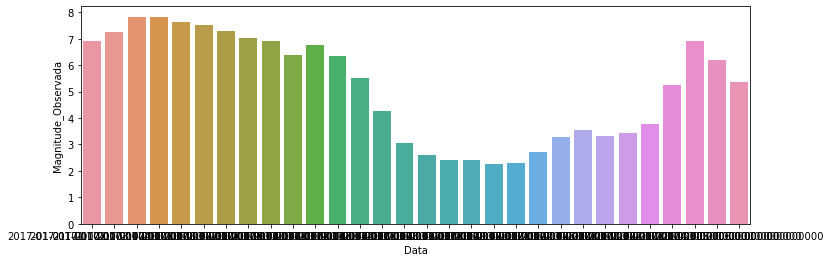

In [63]:
fig_dims = (12, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=df_patio_grafico,x = "Data", y = "Magnitude_Observada", ax=ax)


<AxesSubplot:xlabel='Data', ylabel='Magnitude_Verif'>

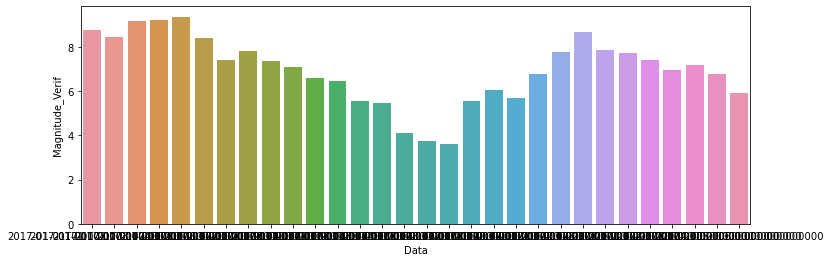

In [64]:
fig_dims = (12, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=df_patio_grafico,x = "Data", y = "Magnitude_Verif", ax=ax)

### <span style="color:Blue"> ***B) Regressão Linear*** 

### <span style="color:#4169E1">**B1. Cálculos**

- slope = Inclinação da linha de regressão.<br>
- intercept= Interceptação da linha de regressão.<br>
- rvalue = Coeficiente de correlação.<br>
- pvalue= Valor p bilateral para um teste de hipótese cuja hipótese nula é que a inclinação é zero, usando o Teste de Wald com distribuição t da estatística de teste<br>
- stderr = (Desvio)Erro padrão da inclinação estimada (gradiente), considerando a normalidade residual.<br>

In [7]:
x = df_patio['Magnitude_Observada'] 
y = df_patio['Magnitude_Verif']
a, b, r, p, std_err = stats.linregress(x,y)

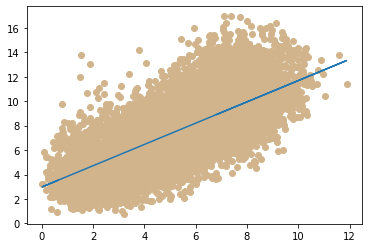

In [8]:
def estimate_y(x):
    return a * x + b

df_patio['y_Magnitude_Verif'] = df_patio['Magnitude_Observada'].apply(estimate_y)  
# A partir da coluna idade, será criado uma nova coluna chamada y_estimado

plt.figure()
plt.plot(df_patio['Magnitude_Observada'], df_patio['y_Magnitude_Verif'])
plt.scatter(df_patio['Magnitude_Observada'], df_patio['Magnitude_Verif'], color='#D2B48C')
plt.show()

### <span style="color:#4169E1">**B2. Coeficiente de Determinação**

In [9]:
coef_determinacao = r**2

print("O acerto da Previsão é de: " + str(coef_determinacao) + " %") # Proximo de 1 é uma boa estimativa

O acerto da Previsão é de: 0.4633678279690343 %


### <span style="color:#8B008B"> ***B) Regressão Linear Multipla*** 

In [10]:
# Método: Ordinary Least Square
# Estimador escolhido: R2

model = ols('Magnitude_Verif ~ Magnitude_Observada + Valor_Pressao + Valor_Temp', data = df_patio)
response = model.fit()
response.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Magnitude_Verif   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     2771.
Date:                Sun, 27 Jun 2021   Prob (F-statistic):               0.00
Time:                        23:55:44   Log-Likelihood:                -18482.
No. Observations:                8760   AIC:                         3.697e+04
Df Residuals:                    8756   BIC:                         3.700e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -121.0789      7.678    -15.769      0.000    -136.130    -106.028
Magnitude_Observada     0.8656      0.012     69.530      0.000       0.841       0.890
Valor_Pressao           0.1196      0.008     15.882      0.000       0.105       0.134
Valor_Temp              0.1067      0.006     17.555      0.000       0.095       0.119
==============================================================================
Omnibus:                      225.169   Durbin-Watson:                   0.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              242.657
Skew:                           0.397   Prob(JB):                     2.03e-53
Kurtosis:                       3.187   Cond. No.                     3.66e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""